In [309]:
import networkx as nx
from pyvis.network import Network

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.axes import Axes
from matplotlib.lines import Line2D
from ipywidgets import interact, IntSlider

from city import *
from constants import *

from enum import Enum

In [310]:



styles = {
    "type0": { # center to task start
        "color": "green",
        "label": "city center to task start",
        "linestyle": "dotted"
    }, 
    "type1": { # task end to center
        "color": "red",
        "label": "task end to city center",
        "linestyle": "dotted" 
    },
    "type2": { # between task
        "color": "blue",
        "label": "between tasks",
        "linestyle": "dashed" 
    },
    "type3": { # task start to task end
        "color": "black",
        "label": "task start to task end",
        "linestyle": "dashed" 
    }
}

def get_path_type(u: int, v: int, start_and_end_id: list[int], n_ids: int) -> str:
    """
        Returns the key of the style keyword args based on the from and to node ids
        Does not check whether the ids are in the correct range yet
    """
    assert len(start_and_end_id) == 2, "wrong number of start and end ids"
    assert u in (range(n_ids)) and v in (range(n_ids)), "u and v are not in the correct range"
    assert not u == v, "self edges not allowed"

    if u == start_and_end_id[0] and v not in start_and_end_id:
        return "type0"
    elif v == start_and_end_id[1] and u not in start_and_end_id:
        return "type1"
    elif v not in start_and_end_id and u not in start_and_end_id:
        return "type2"
        
    else:
        raise Exception("u and v are not in the correct range")
    

def plot_city_edges(city: City, E: list[Edge], ax: Axes, title: str):
    # get props
    task_start_positions = city.positions_start
    task_end_positions = city.positions_end
    n_tasks = city.n_tasks
    start_task_id = n_tasks 
    end_task_id = n_tasks + 1

    # Unzip start and end positions
    start_x, start_y = zip(*task_start_positions)
    end_x, end_y = zip(*task_end_positions)

    # add task nodes and center
    ax.scatter(start_x, start_y, s=50, color='k')
    ax.scatter(end_x, end_y, s=50, color='k', marker='X')
    ax.plot(*city.get_center(), "ks", markersize=10)

    # draw arrows between tasks 
    for e in E:
        u = int(e.from_vertex.name)
        v = int(e.to_vertex.name)
        path_type = get_path_type(u, v, [start_task_id, end_task_id], n_tasks +2)
        args = styles[path_type]

        ux, uy = task_end_positions[u]
        vx, vy = task_start_positions[v]
        dx = vx - ux
        dy = vy - uy
        ax.arrow(ux, uy, dx, dy, head_width=0.5, length_includes_head=True, **args)

    # draw arrows from task starts to task ends
    for n in range(n_tasks + 2):
        dx = end_x[n] - start_x[n]
        dy = end_y[n] - start_y[n]
        args = styles["type3"]
        ax.arrow(start_x[n], start_y[n], dx, dy, head_width=0.3, length_includes_head=True, **args)

    # set axis props
    ax.set_xlim(-5, city.width + 5)
    ax.set_ylim(-5, city.height + 5)
    ax.set_title(title)
    colors = [v["color"] for v in styles.values()]
    labels = [v["label"] for v in styles.values()]
    handles = [Line2D([], [], color=color, label=label)
               for color, label in zip(colors, labels)]
    ax.legend(handles=handles)
    ax.grid(True)
    

def visualize_paths(city: City, vsp_path: list[int] = None):
    """
    Visualizes every reachable path of the city

    @param city -- The City class to visualize.
    @param vsp_path --  The solution path of the SVSP instance. Will not show if none is provided.
    """
    # create edges if not existing
    if len(city.graph.vertices) == 0:
        city.create_graph()
    G = city.graph
    E = list(G.get_edges())

    # the solution path is a list of binary variable indicating the selected edges
    if vsp_path is not None:
        assert len(vsp_path) == len(E), "edge sizes do not match"
        E_vsp = [E[n] for n in range(len(E)) if vsp_path[n] == 1]
        
    # figure
    if vsp_path is not None:
        # Create a figure with two subplots arranged horizontally
        fig, (ax, ax_vsp) = plt.subplots(1, 2, figsize=(40, 15))
        plot_city_edges(city, E, ax, title="tasks")
        plot_city_edges(city, E_vsp, ax_vsp, title="solution")
    else:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(111)
        plot_city_edges(city, E, ax, title="tasks")

    # labels and axis props
    plt.gca().set_aspect('equal')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    
    # Show plot
    plt.show()


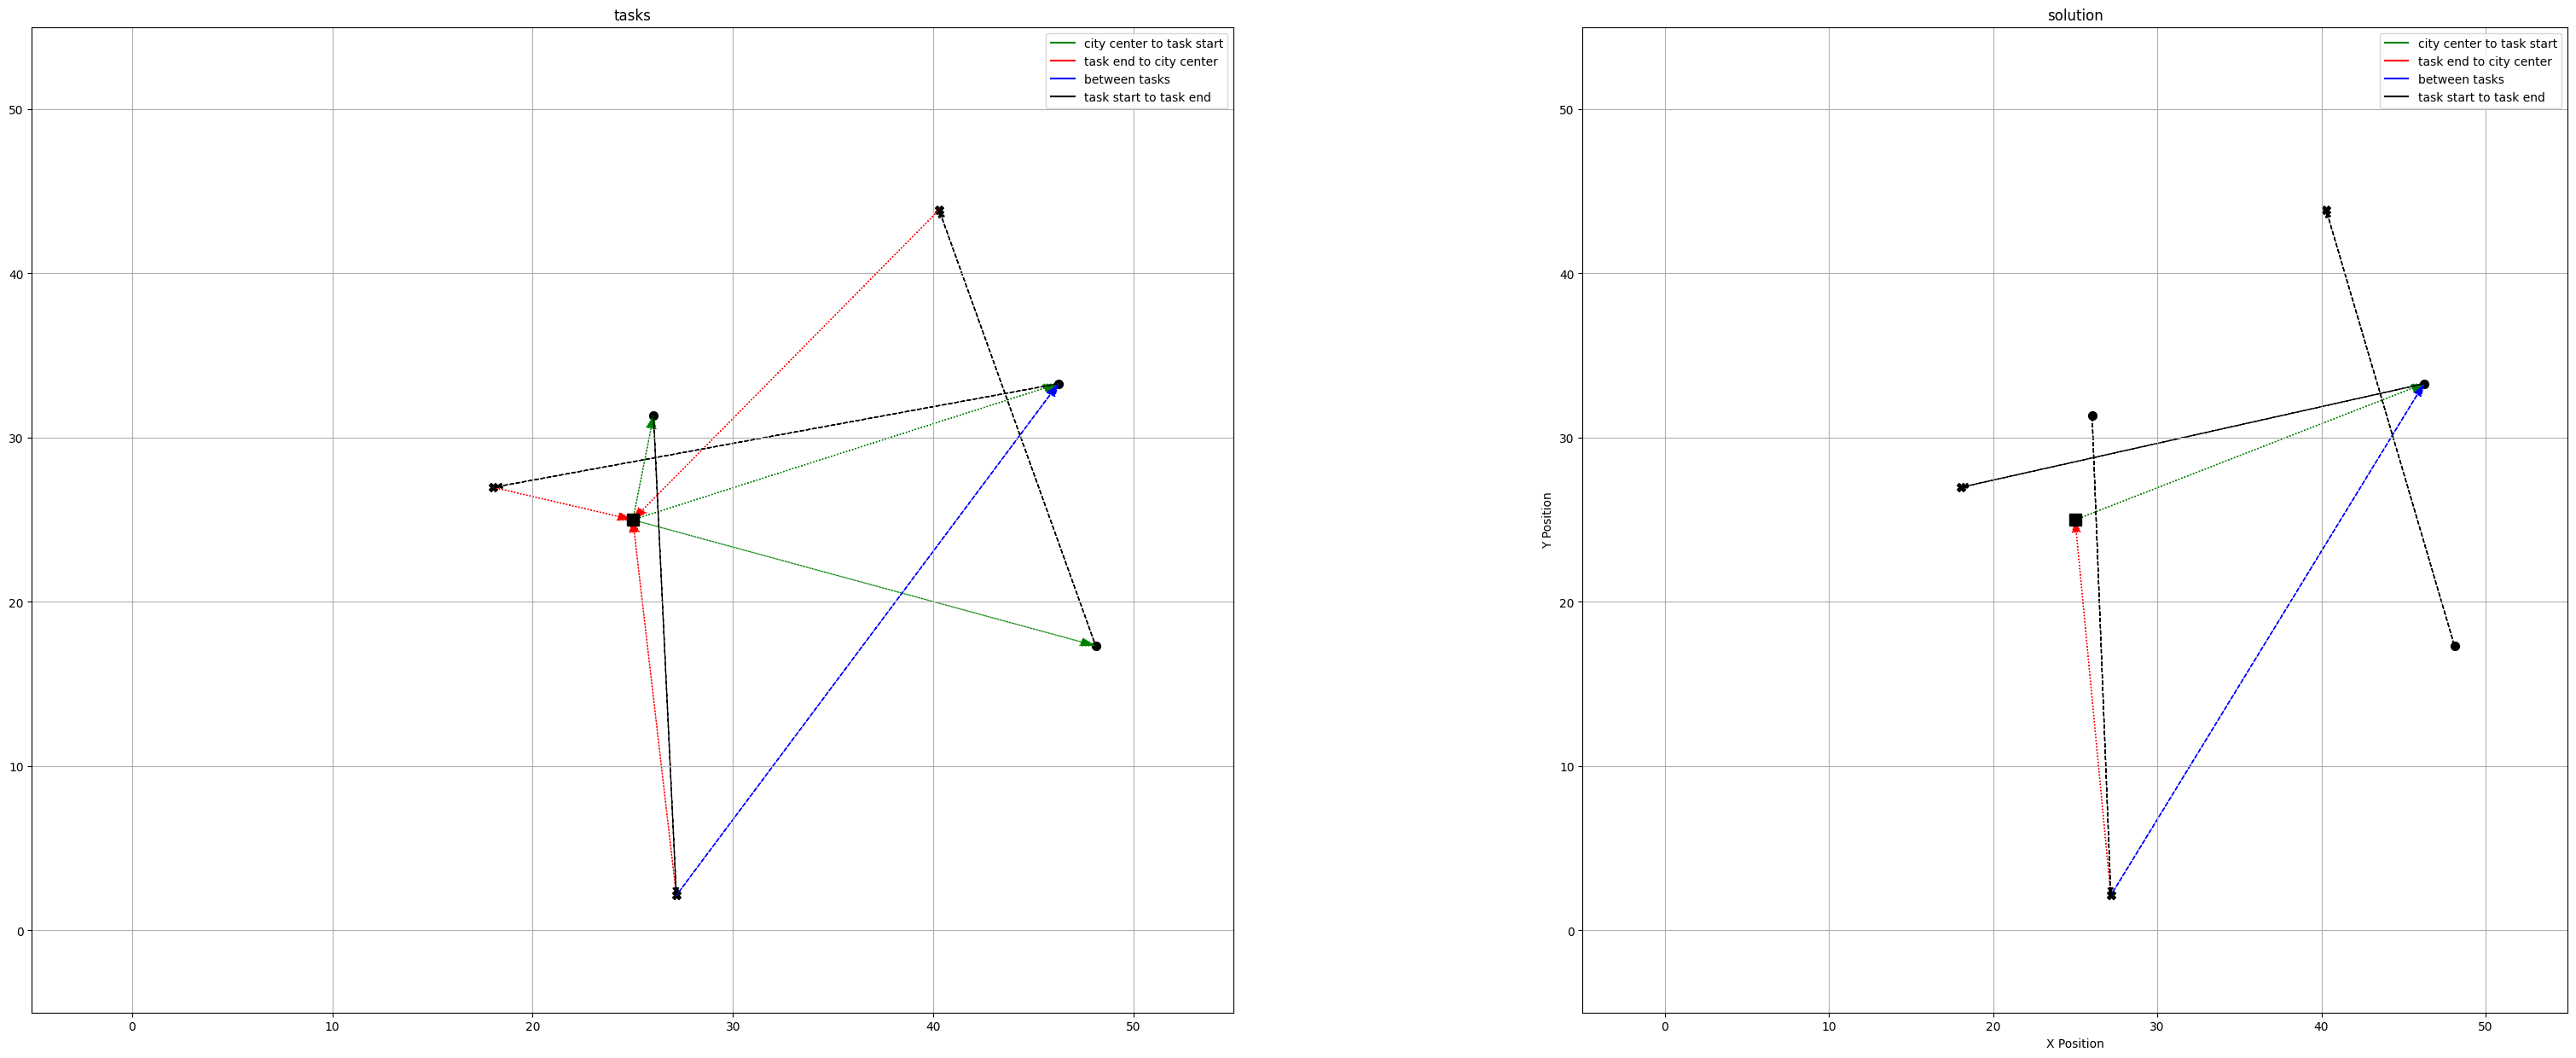

In [324]:
# plot all paths
np.random.seed(51)
n_tasks = 3
city = City(CITY_HEIGHT_MINUTES, CITY_WIDTH_MINUTES, N_DISTRICTS_X, N_DISTRICTS_Y, n_tasks, N_SCENARIOS)
city.create_graph()
N = len(city.graph.get_edges())
labels = np.random.randint(2, size=N)
visualize_paths(city, vsp_path=labels)

In [173]:
def visualize_tasks(city: City, 
                    show_heatmap: bool = False, 
                    vsp_path: list = None, 
                    show_reachable_paths: bool = False):
    """
    Plots every (task start -> task end) of the given city instance on the city map including the center

    Keyword arguments:
    @param city -- The City class to visualize.
    @param show_heatmap -- Plot the heatmap of intra-district delays on the city map, and
                    the heatmap of inter-district delays on a separate figure.
                    Also shows a draggable bar to show the city state corresponding 
                    to a specific time in a day.
    @param vsp_path --  The solution path of the SVSP instance. Will not show if none is provided.
    @param show_reachabele_paths -- Show the reachable paths of the city
    """
    task_start_positions = city.positions_start[:-2]
    task_end_positions = city.positions_end[:-2]
    n_tasks = city.n_tasks
    inter_scenario_delays = city.scenario_delays_inter

    # Unzip start and end positions
    start_x, start_y = zip(*task_start_positions)
    end_x, end_y = zip(*task_end_positions)
    
    # colors
    cm = plt.get_cmap('gist_rainbow')
    # fig, axes = plt.subplots(nrows=3, ncols=1)
    # ax = axes[0]
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111)
    colors = [cm(1.*i/(n_tasks)) for i in range(n_tasks)]
    ax.set_prop_cycle(color=colors)

    # add task nodes
    ax.scatter(start_x, start_y, s=30, color=colors)
    ax.scatter(end_x, end_y, s=30, color=colors, marker='X')

    # add center
    ax.plot(*city.get_center(), "ks", markersize=10)

    # draw arrows
    for start, end, color in zip(task_start_positions, task_end_positions, colors):
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        ax.arrow(start[0], start[1], dx, dy, color=color, head_width=0.3, length_includes_head=True)

    # labels and axis props
    ax.legend()
    ax.set_xlim(-5, city.width + 5)
    ax.set_ylim(-5, city.height + 5)
    plt.gca().set_aspect('equal')
    plt.title('Tasks')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    
    # Show plot
    plt.grid(True)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


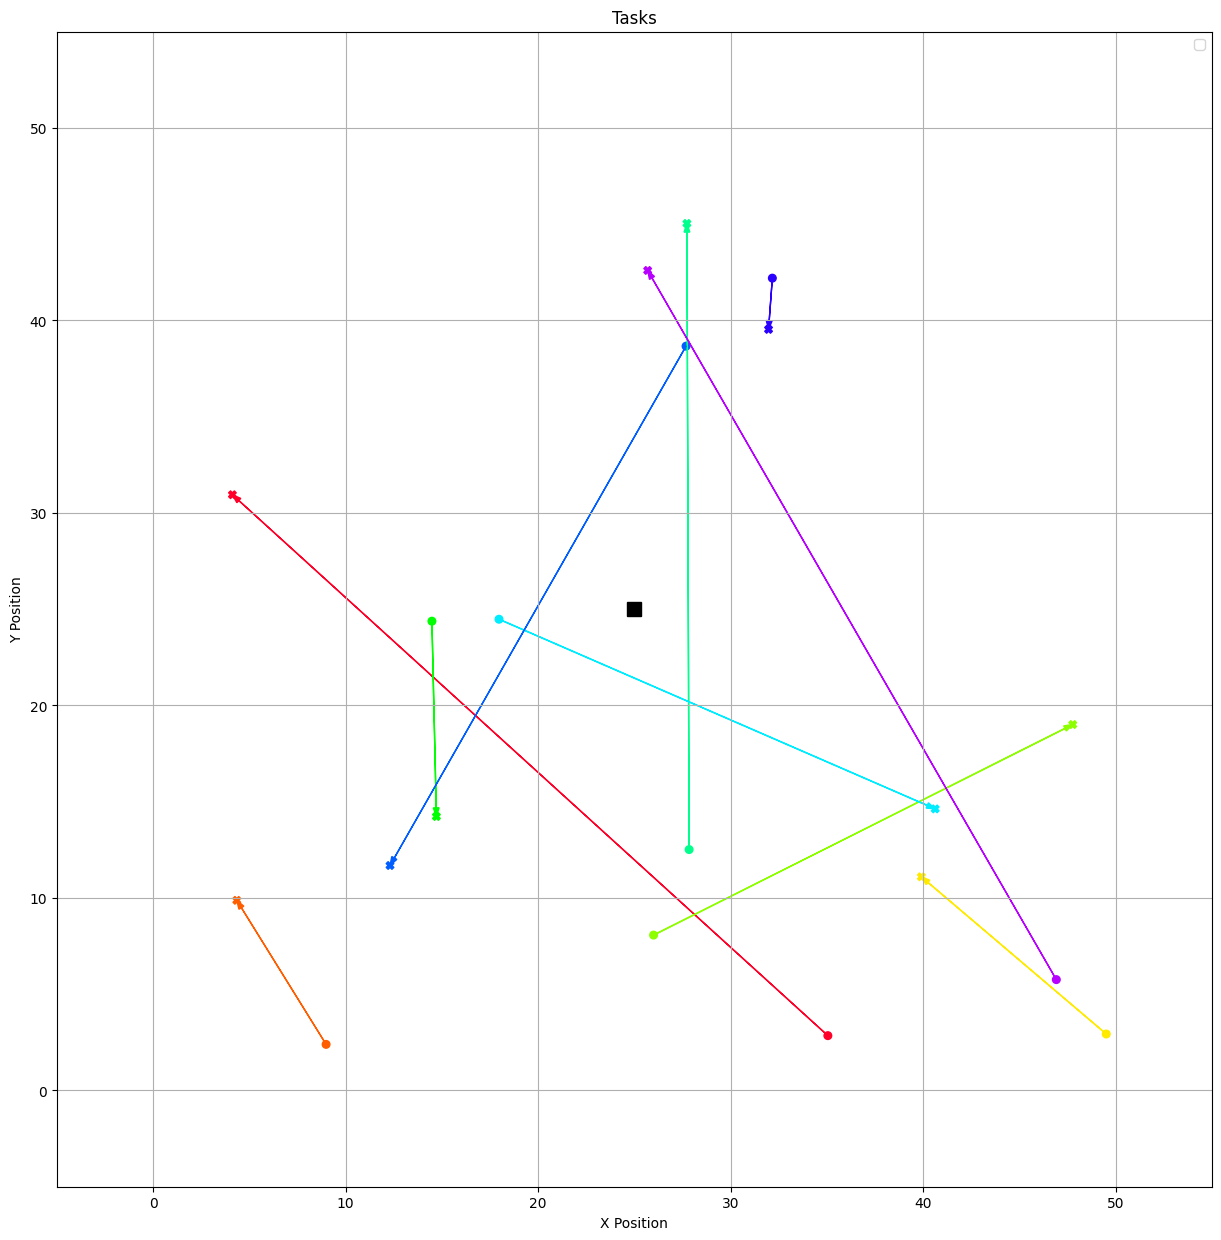

In [308]:
# plot individual tasks
city = City(CITY_HEIGHT_MINUTES, CITY_WIDTH_MINUTES, N_DISTRICTS_X, N_DISTRICTS_Y, N_TASKS, N_SCENARIOS)
visualize_tasks(city)

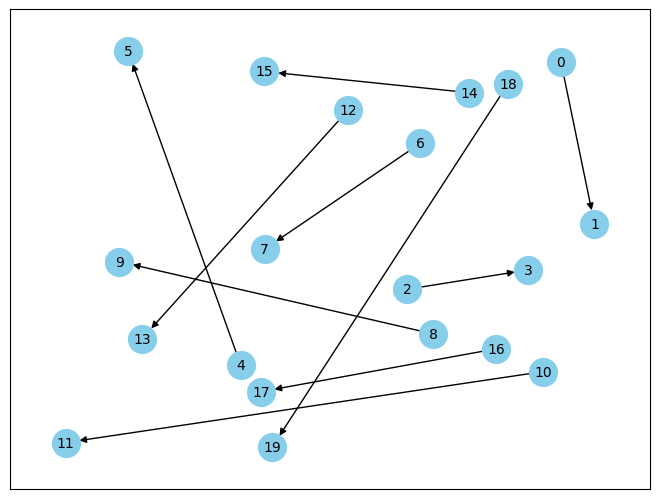

In [34]:
# plot individual tasks in nxGraph
task_start_positions: list[tuple] = city.positions_start
task_end_positions:list[tuple] = city.positions_end
n_tasks = city.n_tasks
start_x, start_y = zip(*task_start_positions)
end_x, end_y = zip(*task_end_positions)

# create new directed graph
G = nx.DiGraph()
for n in range(n_tasks):
    G.add_node(n*2, pos=task_start_positions[n])
    G.add_node(n*2+1, pos=task_end_positions[n])
    G.add_edge(n*2, n*2+1, name=f"task {n}")

# we have to assign node positions mmanually and get the attributes' values
# otherwise nxGraph uses spring_layout by default
pos = nx.get_node_attributes(G,'pos')
nx.draw(G=G, 
        pos=pos,
        with_labels=True, 
        node_size=400, 
        node_color="skyblue", 
        font_size=10, 
        arrows=True)

plt.xticks(range(0, CITY_WIDTH_MINUTES))
plt.yticks(range(0, CITY_HEIGHT_MINUTES))
plt.axis('on')
plt.show()

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111)
# ax.set_axisbelow(True)
# ax.yaxis.grid(color='gray', linestyle='dashed')
# plt.grid(True)